In [136]:
# Загрузим нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import plt, mpl
import seaborn as sns
mpl.rcParams['font.family'] = 'serif'
import math
%matplotlib inline
plt.style.use('fivethirtyeight')
# Чистка отклонений
import scipy.stats as stats
# Уберем warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
# Тематическое моделирование
import gensim

from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [112]:
# Датасет train
train = pd.read_json('train.json')

In [113]:
train.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


In [114]:
# Датасет test
test = pd.read_json('test.json')

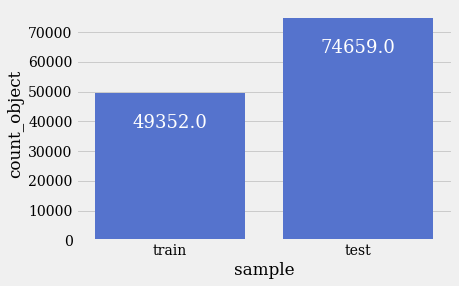

In [115]:
# Проверим количество объектов в train и test
datax = pd.DataFrame({'sample': ['train','test'],
                     'count_object': [len(train), len(test)]})
ax = sns.barplot(x = 'sample', y = 'count_object', data=datax, color = '#4169E1' )
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', 
                (p.get_x()+0.2, p.get_height()),  
                va='top', 
                color='white', 
                size=18)

In [116]:
# Проверим данные на пропуски
train.isna().mean()

bathrooms          0.0
bedrooms           0.0
building_id        0.0
created            0.0
description        0.0
display_address    0.0
features           0.0
latitude           0.0
listing_id         0.0
longitude          0.0
manager_id         0.0
photos             0.0
price              0.0
street_address     0.0
interest_level     0.0
dtype: float64

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [118]:
# Создадим копию исходного датафрейма
df1 = train.copy()

### Посмотрим на распределение таргет переменной

Text(0.5, 1.0, 'Распределение классов в train')

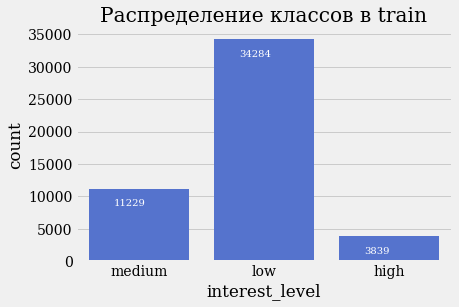

In [119]:
# Посмотрим на распределение interest_level в train
ax=sns.countplot('interest_level', data = df1, color='#4169E1')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', 
                (p.get_x()+0.2, p.get_height()),  
                va='top', 
                color='white', 
                size=10)
plt.title('Распределение классов в train')

In [11]:
### Отсюда можно сделать вывод что классы не сбалансированы

### Посмотрим на распределение спален и ванн

Text(0.5, 1, 'Распределение количества количества ванных и спален в train')

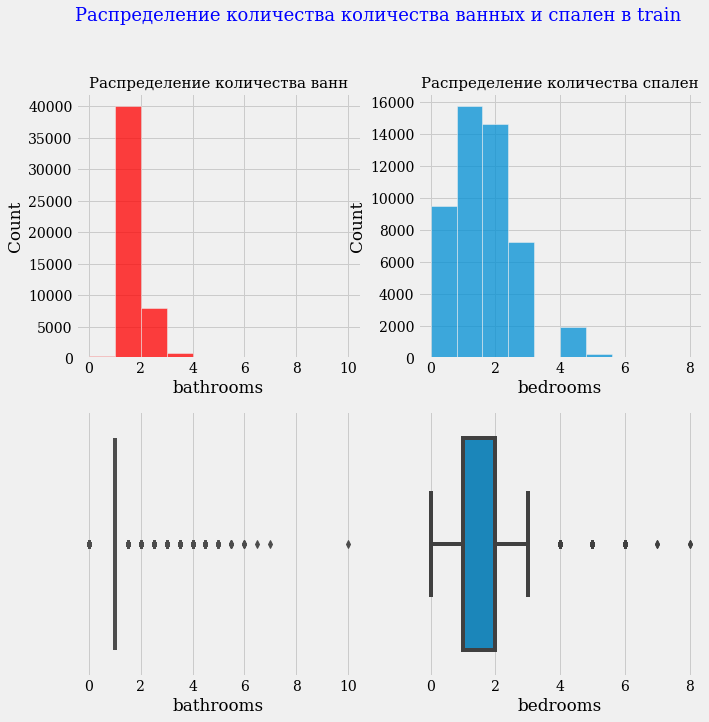

In [120]:
# Посмотрим на распределения спален и ванн в train
# Посмотрим на распределения столбцов
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Выводим Гистограмму
# столбец bathrooms
sns.histplot(train.bathrooms, ax=ax[0, 0], color='red', bins=10)
ax[0, 0].set_title('Распределение количества ванн', size=15)

# bedrooms
sns.histplot(train.bedrooms, ax=ax[0,1], bins=10)
ax[0, 1].set_title('Распределение количества спален', size=15)

# Выводим боксплот
sns.boxplot(train.bathrooms, ax=ax[1,0], color='red')

sns.boxplot(train.bedrooms, ax=ax[1,1])

plt.suptitle('Распределение количества количества ванных и спален в train', size = 18, color='blue', y=1)

In [121]:
# Посмотрим на количество ванных комнат в train
train.bathrooms.value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
7.0         1
6.5         1
10.0        1
Name: bathrooms, dtype: int64

In [122]:
# Посмотрим на количество спальных комнат в train
train.bedrooms.value_counts()

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
7        2
8        2
Name: bedrooms, dtype: int64

#### ВЫВОД
Для однокомнатных квартир гостиная явялется жилой комнатой поэтому подразумеватся комнат 0, но в любом случае должна быть ванная. Поэтому обьявления где количество ванных комнат = 0 некорректно. Их можно посчитать за выбросы.

Text(0.5, 1, 'Распределение количества количества ванных и спален в test')

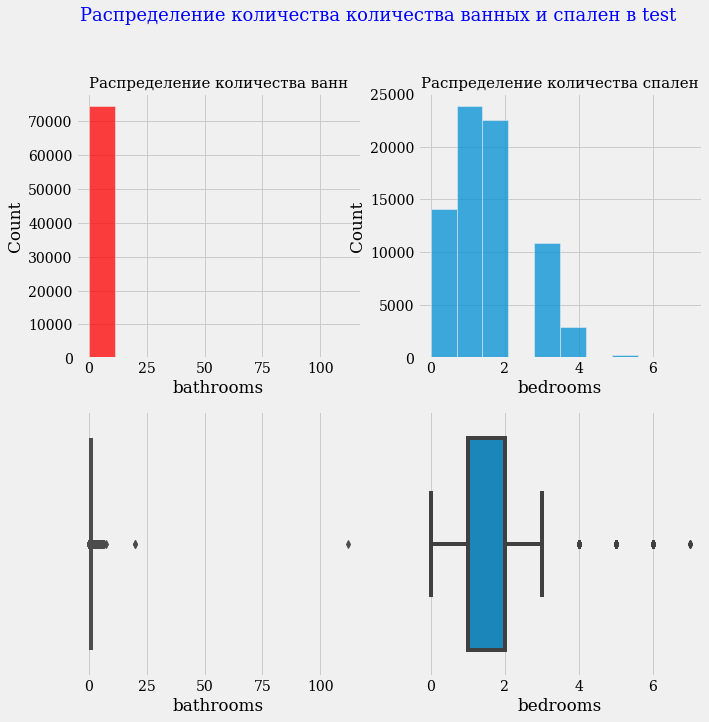

In [123]:
# Посмотрим на распределения спален и ванн в test
# Посмотрим на распределения столбцов
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Выводим Гистограмму
# столбец bathrooms
sns.histplot(test.bathrooms, ax=ax[0, 0], color='red', bins=10)
ax[0, 0].set_title('Распределение количества ванн', size=15)

# bedrooms
sns.histplot(test.bedrooms, ax=ax[0,1], bins=10)
ax[0, 1].set_title('Распределение количества спален', size=15)

# Выводим боксплот
sns.boxplot(test.bathrooms, ax=ax[1,0], color='red')

sns.boxplot(test.bedrooms, ax=ax[1,1])

plt.suptitle('Распределение количества количества ванных и спален в test', size = 18, color='blue', y=1)

### Посмотрим на количество ванн и спален в тестовой выборке

In [124]:
test.bathrooms.value_counts()

1.0      59664
2.0      11570
3.0       1116
1.5        997
0.0        474
2.5        425
4.0        205
3.5         94
4.5         54
5.0         40
5.5          7
6.0          7
20.0         2
6.5          2
112.0        1
7.5          1
Name: bathrooms, dtype: int64

# Распределение цены в train

Text(0.5, 1, 'Распределение цены')

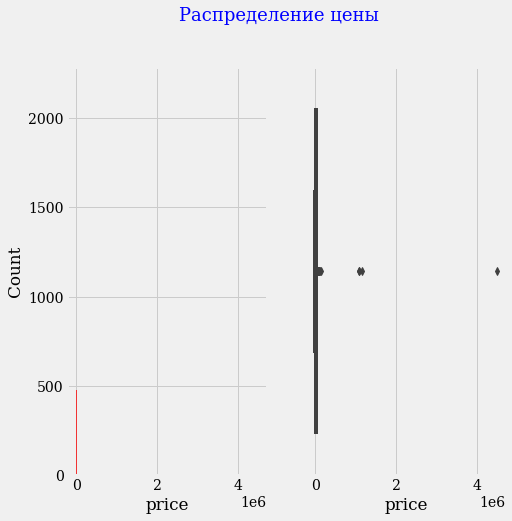

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,7))
sns.histplot(train.price, ax=ax[0], color='red')


# bedrooms
sns.boxplot(train.price, ax=ax[1])
plt.suptitle('Распределение цены', size = 18, color='blue', y=1)

У цены также есть выбросы. Уберем экстремальные значения по цене и посмотрим на распределение

In [126]:
# Отсортируем датафрейм по уменьшению цены
train.sort_values('price', ascending=False)[['bathrooms', 'bedrooms', 'price']].head(10)

,bathrooms,bedrooms,price
32611,1.0,2,4490000
12168,1.0,2,1150000
57803,1.0,1,1070000
55437,1.0,1,1070000
123877,0.0,0,135000
4620,1.0,0,111111
91709,6.0,6,100000
54148,3.0,3,90000
116586,5.0,4,85000
96905,3.0,3,80000


In [127]:
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


#### Построим столбчатую диагрмму до чистки зависимости средней цены от спалены и ванных комнат

Text(0.5, 0.93, 'Изменение цены от количества спален и ванн')

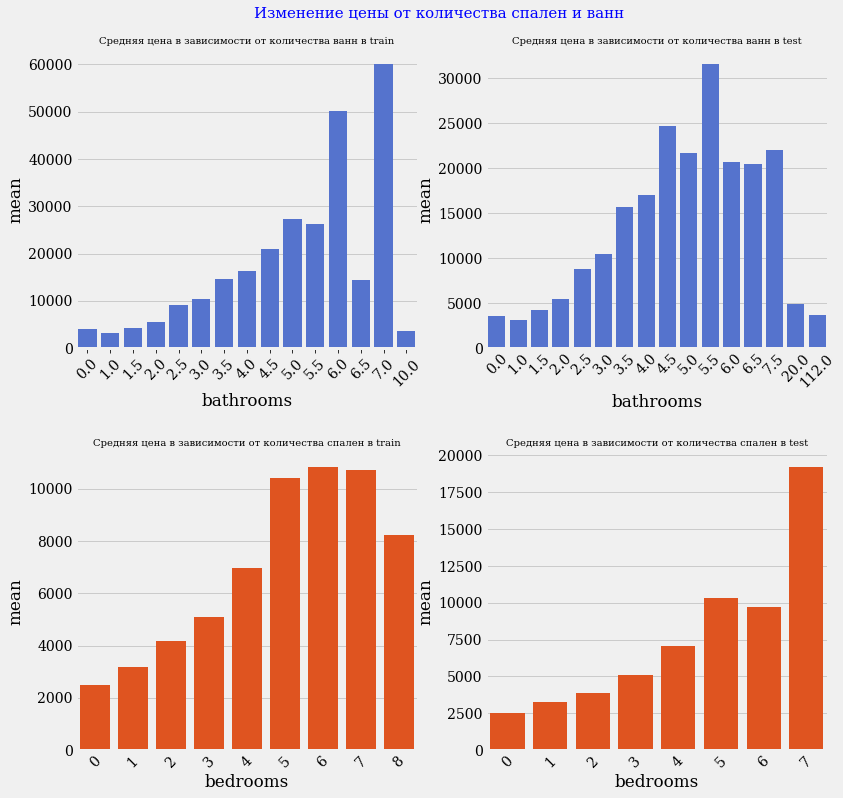

In [128]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
# Создаем сгруппированные данные по средней цене train
train_bathrooms = train.groupby('bathrooms', as_index=False)['price'].agg(['sum', 'mean']).reset_index()
train_bedrooms = train.groupby('bedrooms', as_index=False)['price'].agg(['sum', 'mean']).reset_index()

# Создаем сгруппированные данные по средней цене train
test_bathrooms = test.groupby('bathrooms', as_index=False)['price'].agg(['sum', 'mean']).reset_index()
test_bedrooms = test.groupby('bedrooms', as_index=False)['price'].agg(['sum', 'mean']).reset_index()


# столбец bathrooms train
sns.barplot(x=train_bathrooms['bathrooms'], y = train_bathrooms['mean'], color='#4169E1', ax = ax[0, 0])
ax[0, 0].set_title('Средняя цена в зависимости от количества ванн в train', size=10)
ax[0,0].tick_params(axis='x', labelrotation = 45, size=5)

# столбец bathrooms test
sns.barplot(x=test_bathrooms['bathrooms'], y = test_bathrooms['mean'], color='#4169E1', ax = ax[0, 1])
ax[0, 1].set_title('Средняя цена в зависимости от количества ванн в test', size=10)
ax[0,1].tick_params(axis='x', labelrotation = 45)

# bedrooms train
sns.barplot(x=train_bedrooms['bedrooms'], y = train_bedrooms['mean'], color='#FF4500', ax = ax[1, 0])
ax[1, 0].set_title('Средняя цена в зависимости от количества спален в train', size=10)
ax[1,0].tick_params(axis='x', labelrotation = 45)

# bedrooms test
sns.barplot(x=test_bedrooms['bedrooms'], y = test_bedrooms['mean'], color='#FF4500', ax = ax[1, 1])
ax[1, 1].set_title('Средняя цена в зависимости от количества спален в test', size=10)
ax[1,1].tick_params(axis='x', labelrotation = 45)
fig.subplots_adjust(hspace=0.35)
plt.suptitle('Изменение цены от количества спален и ванн', y=0.93, fontsize=15, color='blue')

В распределении цен однозначно есть ошибки. Это большое количество ванных комнат в test, с ценой меньше чем с двумя ванными в train.
Скорее всего при заполнении количества ванных, подразумевалось 1 ванная или две. Также есть в количестве ванных данные типа float. Тут скорее всего подразумевается, отдельно ванная и туалет.

Для однокомнатных квартир гостиная считается спальным местом, и для нее правильно будет использовать нулевое значение. Однако во всех объявлениях всегда должна быть ванная комната. Имея эту информацию, можно сделать вывод, что объявления с 0 спальнями, но больше 1 ванной комнатой - это корректные данные, а объявления со спальнями и  0 ванными комнатами - некорректные, и данные должны быть удалены.

Также можно заметить, что например в тестовых данных средняя цена при 20 ванных комнатах примерно равна средней цене при 2х комнатах. Значит при заполнении получена ошибка

In [129]:
# Средняя цена квартиры с двумя ванными
train[train.bathrooms == 2.0].price.mean()

5501.066971279373

In [130]:
# Средняя цена в тесте с 20 ванными
test[test.bathrooms == 20.0].price.mean()

4950.0

In [131]:
# Средняя цена квартиры с 1 ванной
train[train.bathrooms == 1.0].price.mean()

3233.9404900816803

In [132]:
# Средняя цена квартиры с 112 ванными
test[test.bathrooms == 112.0].price.mean()

3700.0

Со 112 ванными комнатами точно также, скорее всего имеется ввиду 1 комната

### Посмотрим на распределение `longitude` и  `latitude` ( долгота и широта)

### Train

Text(0.5, 1, 'Распределение долготы и широты в train')

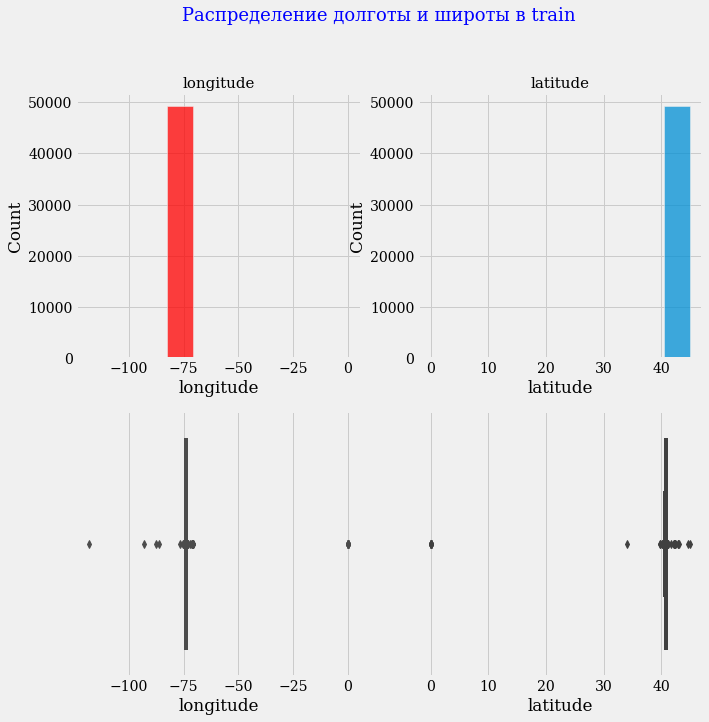

In [133]:
# Посмотрим на распределения i
# Посмотрим на распределения столбцов
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Выводим Гистограмму
# столбец longitude
sns.histplot(train.longitude, ax=ax[0, 0], color='red', bins=10)
ax[0, 0].set_title('longitude', size=15)

# latitude
sns.histplot(train.latitude, ax=ax[0,1], bins=10)
ax[0, 1].set_title('latitude', size=15)

# Выводим боксплот
sns.boxplot(train.longitude, ax=ax[1,0], color='red')

sns.boxplot(train.latitude, ax=ax[1,1])

plt.suptitle('Распределение долготы и широты в train', size = 18, color='blue', y=1)

## Test

Text(0.5, 1, 'Распределение долготы и широты в test')

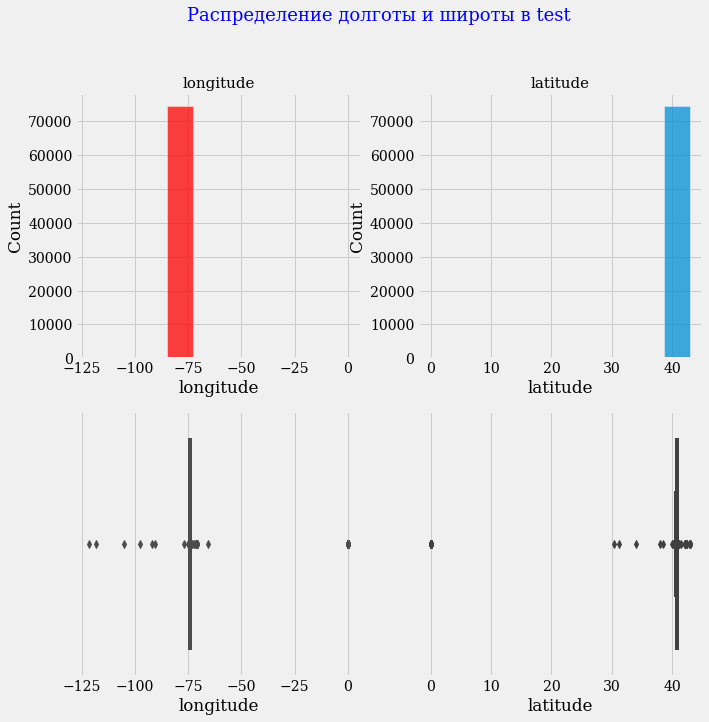

In [134]:
# Посмотрим на распределения широты и долготы
# Посмотрим на распределения столбцов
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Выводим Гистограмму
# столбец longitude
sns.histplot(test.longitude, ax=ax[0, 0], color='red', bins=10)
ax[0, 0].set_title('longitude', size=15)

# latitude
sns.histplot(test.latitude, ax=ax[0,1], bins=10)
ax[0, 1].set_title('latitude', size=15)

# Выводим боксплот
sns.boxplot(test.longitude, ax=ax[1,0], color='red')

sns.boxplot(test.latitude, ax=ax[1,1])

plt.suptitle('Распределение долготы и широты в test', size = 18, color='blue', y=1)

In [135]:
train.longitude.describe()

count    49352.000000
mean       -73.955716
std          1.177912
min       -118.271000
25%        -73.991700
50%        -73.977900
75%        -73.954800
max          0.000000
Name: longitude, dtype: float64

In [136]:
train.latitude.describe()

count    49352.000000
mean        40.741545
std          0.638535
min          0.000000
25%         40.728300
50%         40.751800
75%         40.774300
max         44.883500
Name: latitude, dtype: float64

### Вывод: 

Столбцы Longitude и Latitude без фильтрации показали, что средние значения 49352 объявлений составили -73,955716 и 40,741545, а максимальные значения - 0 и 44,8835. Минимальные -118.271000, 0. Координаты выходят за пределы Нью-Йорка. Потому большинство данных по координатам ошибочны 

### Чистка TRAIN

In [137]:
train2 = pd.read_json('train.json')

In [138]:
# Удалим значения где количество ванных рано нулю
train2 = train[train.bathrooms > 0].copy()
train2.head(5)
# Выбросы по ванным уберем через z-score
z_bath = np.abs(stats.zscore(train2.bathrooms))
train2 = train2[np.abs(stats.zscore(train2.bathrooms)) < 3]

#### Координаты

In [139]:
# Почистим выбросы по долготе и широте через оценку z 
# Широта

z4 = np.abs(stats.zscore(train2['longitude']))
train2 = train2[z4 < 3]
# Долгота
z3 = np.abs(stats.zscore(train2['latitude']))
train2 = train2[z3 < 3]


Text(0.5, 1.0, 'latitude')

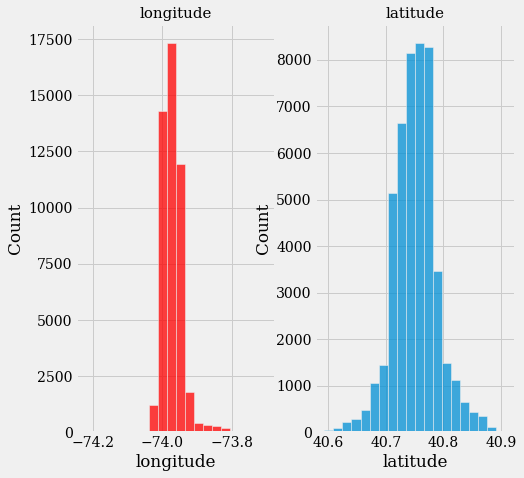

In [140]:
### Посмотрим на рспределения
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,7))

# Выводим Гистограмму
# столбец longitude
sns.histplot(train2.longitude, ax=ax[0], color='red', bins=20)
ax[0].set_title('longitude', size=15)

# latitude
sns.histplot(train2.latitude, ax=ax[1], bins=20)
ax[1].set_title('latitude', size=15)

####  Диапазон широты и долготы попадает в диапазон Нью Йорка  `40.7143°, -74.006°`.

### Уберем выбросы по `price` 

In [141]:
zm = np.abs(stats.zscore(train2['price']))
train2 = train2[zm < 3]

## Чистка TEST ( НА сырых данных модель ведет лучше)

 Заменим количество ванных комнат 20 и 112 на 1 и 2.
 Также с учетом того, что ванных комнат с 0 значением нету. То заменим их на 1

In [142]:
# Меняем 20 ванных на 2
test.bathrooms=np.where((test.bathrooms ==20.0), 2.0, test.bathrooms)
# Меняем 112 ванных на 1
test.bathrooms=np.where((test.bathrooms ==112.0), 1.0, test.bathrooms)
# Меняем 0 ванных на 1
test.bathrooms=np.where((test.bathrooms ==0.0), 1.0, test.bathrooms)

# Изменение цены
# Склеиваем два датафрейма
df_kl = pd.concat([train, test_df])
zx = np.abs(stats.zscore(df_kl['price']))
# Меняем значения 
df_kl = df_kl[zx < 3]
test_df['price'] = df_kl.groupby(['bathrooms', 'bedrooms'])['price'].transform('mean')

#### Координаты в тесте имеют экстремальные занчения. Идея такая, что координаты по идее можно восстановить по адресу. На данный момент просто заменим их координатой Нью Йорка

In [316]:
# Замена широты
test['latitude'] = np.where((np.abs(stats.zscore(test['latitude'])) > 3), 40.741545, test.latitude)
# Замена долготы
test['longitude'] = np.where((np.abs(stats.zscore(test['longitude'])) > 3), -73.955716, test.longitude)

In [48]:
# Преобразуем таргет в числовые значения
num_target = {'high':0, 'medium':1, 'low':2}
df_train['interest_level'] = df_train['interest_level'].apply(lambda x: num_target[x])

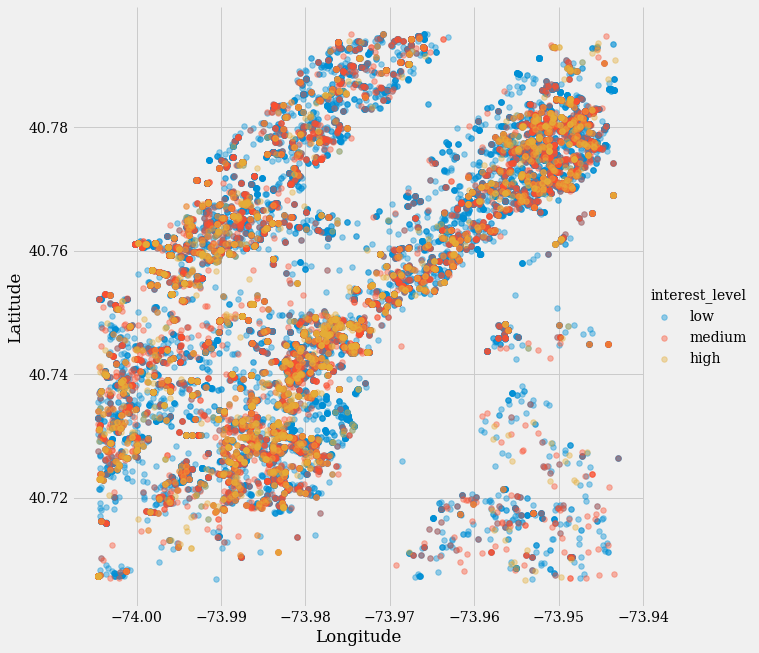

In [65]:
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=9, scatter_kws={'alpha':0.4,'s':30},
           data=train[(train.longitude>train.longitude.quantile(0.1))
                        &(train.longitude<train.longitude.quantile(0.9))
                        &(train.latitude>train.latitude.quantile(0.1))                           
                        &(train.latitude<train.latitude.quantile(0.9))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');

#### Вывод по координатам:
Координаты нужно привязывать или искать расстояние от близости к метро. Это как фича. 

### Тематическое моделирование. Идея была в следующем:
Каждый объект недвижимости имеет свои признаки. Можно разбить эти признаки на количество тематик. Для выделения оптимального количества тематик была написана функция. Работает довольно долго.
В итоге было взято для теста 7 тем. Score тем самым ухудшился

### Функция назначения топика темы по признакам

In [143]:
# Фичи полученные функцией не работают
def get_topic(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0])) 
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    return [main_topic, main_probability]


def them_topic(data, features):
    gensim_dictionary = gensim.corpora.Dictionary(data[features])
    gensim_dictionary.filter_extremes(no_above=0.1, no_below=20)
    gensim_dictionary.compactify()

# Создаем корпус слов
    corpus = [gensim_dictionary.doc2bow(text) 
          for text in data[features]]

    lda_7 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=7, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

    data["lda_7"] = data[features].apply(get_topic, lda=lda_7)

    data["topic_7"] = data["lda_7"].str[0].astype('float64')
    del data["lda_7"]
    return data

#### Функция графияечкого определения оптимального количества тем

In [144]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):
    """
    Функция вычисляет метрики для оценки тем. моделирования и выводит 
    график, где по оси x отложено количество топиков, а по оси y — значение 
    метрики
    :param dictionary: словарь для тематического моделирования
    :param corpus: корпус в виде мешка слов
    :param texts: тексты документов
    :param max: максимальное количество топиков
    :param start: стартовое количество топиков
    :param step: промежуток, с которым вычисляются топики
    :param measure: метрика
    """
    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=10, num_topics=num_topics, 
                                           random_state=6457)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()


##  модель XGB

In [14]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1                #  скорость обучения
    param['max_depth'] = 6             # Глубина дерева
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 5
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [15]:
features_to_use  = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']

In [16]:
# Тематическое моделирование
#test_df = them_topic(test_df, features='features')
#train_df = them_topic(train_df, features='features')

train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')




# Функция расчета расстояния от манхэттэна
def distance_pair(lat1, lon1, lat2, lon2):
    # Перевод в радианы
    p = 0.017453292519943295     #Pi/180
    haver_formula = 0.5 - np.cos((lat2 - lat1) * p)/2 +  np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    d_2_point = 6367 *2 * np.arcsin(np.sqrt(haver_formula)) 
    return d_2_point
distance_pairs = np.vectorize(distance_pair)


train_df['distance_manh'] = distance_pairs(train_df.latitude, train_df.longitude, 40.70858733058446, -74.01098113951349)
test_df['distance_manh'] = distance_pairs(test_df.latitude, test_df.longitude, 40.70858733058446, -74.01098113951349)

train_df['distance_central_park'] = distance_pairs(train_df.latitude, train_df.longitude, 40.782554722204516, -73.96795481545902)
test_df['distance_central_park'] = distance_pairs(test_df.latitude, test_df.longitude, 40.782554722204516, -73.96795481545902)

train_df['bronx'] = distance_pairs(train_df.latitude, train_df.longitude, 40.944369475250284, -73.82958254429063)
test_df['bronx'] = distance_pairs(test_df.latitude, test_df.longitude, 40.944369475250284, -73.82958254429063)

# Кластеризация координат
geo = ['latitude', 'longitude']
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

# Метки кластеров внесем в переменную clusters
train_df['clusters'] = kmeans.fit(train_df[geo]).labels_
test_df['clusters'] = kmeans.fit(test_df[geo]).labels_


#test_df = test.copy()


train_df['num_photos'] = train_df['photos'].apply(len)
test_df['num_photos'] = test_df['photos'].apply(len)

# Число признаков
train_df['num_features'] = train_df['features'].apply(len)
test_df['num_features'] = test_df['features'].apply(len)

# Количество слов
train_df['num_description_words'] = train_df['description'].apply(lambda x: len(x.split(" ")))
test_df['num_description_words'] = test_df['description'].apply(lambda x: len(x.split(" ")))

# Даты
train_df['created'] = pd.to_datetime(train_df['created'])
test_df['created'] = pd.to_datetime(test_df['created'])

# Извлекаем время
train_df['created_year'] = train_df['created'].dt.year
test_df['created_year'] = test_df['created'].dt.year
train_df['created_month'] = train_df['created'].dt.month
test_df['created_month'] = test_df['created'].dt.month
train_df['created_day'] = train_df['created'].dt.day
test_df['created_day'] = test_df['created'].dt.day
train_df['created_hour'] = train_df['created'].dt.hour
test_df['created_hour'] = test_df['created'].dt.hour

# Фичи по ванной и спальням
# Разл в комнатах
train_df['room_difference'] = train_df['bedrooms'] - train_df['bathrooms']
test_df['room_difference'] = test_df['bedrooms'] - test_df['bathrooms']
# Общее количество
train_df['total_rooms'] = train_df['bedrooms'] + train_df['bathrooms']
test_df['total_rooms'] = test_df['bedrooms'] + test_df['bathrooms']
# Цена 1 добавляется чтобы исключить деление на ноль
train_df['price_per_room'] = train_df['price'] / (train_df['total_rooms'] + 1)
test_df['price_per_room'] = test_df['price'] / (test_df['total_rooms'] + 1)


# adding all these new features to use list #
features_to_use.extend(['num_photos', 
                        'num_features', 
                        'num_description_words',
                        'created_year', 
                        'created_month', 
                        'created_day', 
                        'listing_id', 
                        'created_hour', 
                        'clusters',
                        'distance_manh',
                        'distance_central_park',
                        'room_difference',
                        'total_rooms',
                        'price_per_room',
                         'bronx'])

In [17]:
categorical = ['display_address', 'manager_id', 'building_id', 'street_address']
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

In [18]:
train_df['features'] = train_df['features'].apply(lambda x: ' '.join(["_".join(i.split(' ')) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: ' '.join(["_".join(i.split(' ')) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df['features'])
te_sparse = tfidf.transform(test_df['features'])

4     Dining_Room Pre-War Laundry_in_Building Dishwa...
6     Doorman Elevator Laundry_in_Building Dishwashe...
9     Doorman Elevator Laundry_in_Building Laundry_i...
10                                                     
15    Doorman Elevator Fitness_Center Laundry_in_Bui...
Name: features, dtype: object


In [19]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(49352, 224) (74659, 224)


In [20]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[04:58:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:1.03729	test-mlogloss:1.03801
[1]	train-mlogloss:0.98313	test-mlogloss:0.98478
[2]	train-mlogloss:0.94004	test-mlogloss:0.94220
[3]	train-mlogloss:0.89964	test-mlogloss:0.90264
[4]	train-mlogloss:0.86614	test-mlogloss:0.87014
[5]	train-mlogloss:0.83773	test-mlogloss:0.84233
[6]	train-mlogloss:0.81105	test-mlogloss:0.81635
[7]	train-mlogloss:0.78884	test-mlogloss:0.79473
[8]	train-mlogloss:0.76769	test-mlogloss:0.77416
[9]	train-mlogloss:0.74876	test-mlogloss:0.75607
[10]	train-mlogloss:0.73242	test-mlogloss:0.74055
[11]	train-mlogloss:0.71766	test-mlogloss:0.72663
[12]	train-mlogloss:0.70383	test-mlogloss:0.71329
[13]	train-mlogloss:0.69161	test-mlogloss:0.70210
[14]	train-mlogloss:0.68068	test-mlogloss:0.69190
[15]	train-mlogloss:0.67013	test-mlogloss:0.68211
[16]	train-mlo

[159]	train-mlogloss:0.45331	test-mlogloss:0.54375
[160]	train-mlogloss:0.45285	test-mlogloss:0.54364
[161]	train-mlogloss:0.45229	test-mlogloss:0.54359
[162]	train-mlogloss:0.45178	test-mlogloss:0.54347
[163]	train-mlogloss:0.45120	test-mlogloss:0.54331
[164]	train-mlogloss:0.45065	test-mlogloss:0.54312
[165]	train-mlogloss:0.45004	test-mlogloss:0.54293
[166]	train-mlogloss:0.44956	test-mlogloss:0.54284
[167]	train-mlogloss:0.44905	test-mlogloss:0.54278
[168]	train-mlogloss:0.44871	test-mlogloss:0.54267
[169]	train-mlogloss:0.44834	test-mlogloss:0.54256
[170]	train-mlogloss:0.44771	test-mlogloss:0.54248
[171]	train-mlogloss:0.44698	test-mlogloss:0.54243
[172]	train-mlogloss:0.44667	test-mlogloss:0.54234
[173]	train-mlogloss:0.44604	test-mlogloss:0.54233
[174]	train-mlogloss:0.44558	test-mlogloss:0.54235
[175]	train-mlogloss:0.44503	test-mlogloss:0.54231
[176]	train-mlogloss:0.44438	test-mlogloss:0.54220
[177]	train-mlogloss:0.44382	test-mlogloss:0.54205
[178]	train-mlogloss:0.44316	te

[320]	train-mlogloss:0.37928	test-mlogloss:0.53701
[321]	train-mlogloss:0.37911	test-mlogloss:0.53705
[322]	train-mlogloss:0.37861	test-mlogloss:0.53701
[0.5370229057715667]


In [21]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("bronx_xgboost.csv", index=False)

[04:59:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



# Catboost

In [147]:
from catboost import Pool, CatBoostClassifier
from numpy.random import seed

### Дублирую код себе для удобства

In [189]:
# Тематическое моделирование
#test_df = them_topic(test_df, features='features')
#train_df = them_topic(train_df, features='features')



train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')



train_df['features'] = [','.join(map(str, i)) for i in train_df['features']]
test_df['features'] = [','.join(map(str, i)) for i in test_df['features']]



# Функция расчета расстояния от манхэттэна
def distance_pair(lat1, lon1, lat2, lon2):
    # Перевод в радианы
    p = 0.017453292519943295     #Pi/180
    haver_formula = 0.5 - np.cos((lat2 - lat1) * p)/2 +  np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    d_2_point = 6367 *2 * np.arcsin(np.sqrt(haver_formula)) 
    return d_2_point
distance_pairs = np.vectorize(distance_pair)


train_df['distance_manh'] = distance_pairs(train_df.latitude, train_df.longitude, 40.70858733058446, -74.01098113951349)
test_df['distance_manh'] = distance_pairs(test_df.latitude, test_df.longitude, 40.70858733058446, -74.01098113951349)

train_df['distance_central_park'] = distance_pairs(train_df.latitude, train_df.longitude, 40.782554722204516, -73.96795481545902)
test_df['distance_central_park'] = distance_pairs(test_df.latitude, test_df.longitude, 40.782554722204516, -73.96795481545902)

# Самый бедный район Нью-Йорка
train_df['bronx'] = distance_pairs(train_df.latitude, train_df.longitude, 40.944369475250284, -73.82958254429063)
test_df['bronx'] = distance_pairs(test_df.latitude, test_df.longitude, 40.944369475250284, -73.82958254429063)


# Кластеризация координат
geo = ['latitude', 'longitude']
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

# Метки кластеров внесем в переменную clusters
train_df['clusters'] = kmeans.fit(train_df[geo]).labels_
test_df['clusters'] = kmeans.fit(test_df[geo]).labels_


#test_df = test.copy()


train_df['photos'] = train_df['photos'].apply(len)
test_df['photos'] = test_df['photos'].apply(len)

# Число признаков
train_df['num_features'] = train_df['features'].apply(len)
test_df['num_features'] = test_df['features'].apply(len)

# Количество слов
train_df['num_description_words'] = train_df['description'].apply(lambda x: len(x.split(" ")))
test_df['num_description_words'] = test_df['description'].apply(lambda x: len(x.split(" ")))


# Даты
train_df['created'] = pd.to_datetime(train_df['created'])
test_df['created'] = pd.to_datetime(test_df['created'])

# Извлекаем время
train_df['created_year'] = train_df['created'].dt.year
test_df['created_year'] = test_df['created'].dt.year
train_df['created_month'] = train_df['created'].dt.month
test_df['created_month'] = test_df['created'].dt.month
train_df['created_day'] = train_df['created'].dt.day
test_df['created_day'] = test_df['created'].dt.day
train_df['created_hour'] = train_df['created'].dt.hour
test_df['created_hour'] = test_df['created'].dt.hour



# Фичи по ванной и спальням
# Разл в комнатах
train_df['room_difference'] = train_df['bedrooms'] - train_df['bathrooms']
test_df['room_difference'] = test_df['bedrooms'] - test_df['bathrooms']
# Общее количество
train_df['total_rooms'] = train_df['bedrooms'] + train_df['bathrooms']
test_df['total_rooms'] = test_df['bedrooms'] + test_df['bathrooms']
# Цена 1 добавляется чтобы исключить деление на ноль
train_df['price_per_room'] = train_df['price'] / (train_df['total_rooms'] + 1)
test_df['price_per_room'] = test_df['price'] / (test_df['total_rooms'] + 1)



# Близость к метро
subway = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv') # сторонние данные
subway = subway[['Station Name', 'Station Latitude', 'Station Longitude']]
subway = subway.groupby(['Station Name']).mean().reset_index(drop=True)


# Функция минимального расстояния от метро
def get_subway_distance(location):
    distances = distance_pairs(location[0], location[1], subway['Station Latitude'], subway['Station Longitude'])    
    return min(distances)

# Расчет минимальной дистанции до метро
train_df['location'] = train_df[['latitude', 'longitude']].values.tolist()
test_df['location'] = test_df[['latitude', 'longitude']].values.tolist()

train_df['subway_distance'] = train_df['location'].apply(get_subway_distance)
test_df['subway_distance'] = test_df['location'].apply(get_subway_distance)






train_df["pos"] = train_df.longitude.round(3).astype(str) + '_' + train_df.latitude.round(3).astype(str)
test_df["pos"] = test_df.longitude.round(3).astype(str) + '_' + test_df.latitude.round(3).astype(str)

vals = train_df['pos'].value_counts()
dvals = vals.to_dict()
train_df["density"] = train_df['pos'].apply(lambda x: dvals.get(x, vals.min()))
test_df["density"] = test_df['pos'].apply(lambda x: dvals.get(x, vals.min()))

In [190]:
train_df["price_latitude"] = (train_df["price"])/ (train_df["latitude"]+1.0)
test_df["price_latitude"] =  (test_df["price"])/ (test_df["latitude"]+1.0)

train_df["price_longtitude"] = (train_df["price"])/ (train_df["longitude"]-1.0)
test_df["price_longtitude"] =  (test_df["price"])/ (test_df["longitude"]-1.0)  

In [192]:
list_feat = ['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude','listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'distance_manh', 'distance_central_park', 'bronx', 'clusters',
       'num_features', 'num_description_words', 'created_year',
       'created_month', 'created_day', 'created_hour', 'room_difference',
       'total_rooms', 'price_per_room', 'subway_distance', "density", "price_latitude", "price_longtitude"]

list_test = ['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address',
       'distance_manh', 'distance_central_park', 'bronx', 'clusters',
       'num_features', 'num_description_words', 'created_year',
       'created_month', 'created_day', 'created_hour', 'room_difference',
       'total_rooms', 'price_per_room', 'subway_distance', "density",
        "price_latitude", "price_longtitude"]

train_df = train_df[list_feat]
test_df = test_df[list_test]

In [193]:
# Текстовые данные
#Колонки для чистки текста
cols_text = ['description', 'display_address', 'street_address', 'features']
#Преобразуем в тип str
train_df[cols_text] = train_df[cols_text].astype(str)

test_df[cols_text] = test_df[cols_text].astype(str)

#To lower case

train_df[cols_text] = train_df[cols_text].apply(lambda x: x.str.lower())
test_df[cols_text] = test_df[cols_text].apply(lambda x: x.str.lower())

#Remove punctuation
with_whitespace = ['&', '(', ')', "-", "_", ':', '=', '"', ',']
with_empty = ['.', "'", '`', '!', '*', '#', '/', '<', '>', 'br',
              ';', '$', '%', '|', '+', '?']


def replace_symbol(df, to_replace, replace_by):
    for symbol in to_replace:
        df = df.apply(lambda x: x.str.replace(symbol, replace_by, regex = True)) 
    return df

train_df[cols_text] = replace_symbol(train_df[cols_text], with_whitespace, ' ')
train_df[cols_text] = replace_symbol(train_df[cols_text], with_empty, '')

test_df[cols_text] = replace_symbol(test_df[cols_text], with_whitespace, ' ')
test_df[cols_text] = replace_symbol(test_df[cols_text], with_empty, '')

In [194]:
# Ищу элементы в текстовых данных
desc_feat = ['description', 'features']
#ссылки
train_df[desc_feat] = train_df[desc_feat].replace('\swww.\S*', ' weblink ', regex = True)
#почты
train_df[desc_feat] = train_df[desc_feat].replace('\s\S*@\S*', ' emailaddress', regex = True)
#время
train_df[desc_feat] = train_df[desc_feat].replace('\s\d{1,2}\s\d\d[ap]m', ' ampmtime', regex = True)
#номера
train_df[desc_feat] = train_df[desc_feat].replace('\s\d{2,4}\s\d{2,4}\s\d{2,4}', ' phonenumber', regex = True)


test_df[desc_feat] = test_df[desc_feat].replace('\swww.\S*', ' weblink ', regex = True)
#почты
test_df[desc_feat] = test_df[desc_feat].replace('\s\S*@\S*', ' emailaddress', regex = True)
#timeвремя
test_df[desc_feat] = test_df[desc_feat].replace('\s\d{1,2}\s\d\d[ap]m', ' ampmtime', regex = True)
#номера
test_df[desc_feat] = test_df[desc_feat].replace('\s\d{2,4}\s\d{2,4}\s\d{2,4}', ' phonenumber', regex = True)

In [195]:
# Чистка текста
adr_feat = ['display_address', 'street_address']


train_df[adr_feat] = train_df[adr_feat].replace(['\sst\s', '\sst$'], ' street', regex = True)
train_df[adr_feat] = train_df[adr_feat].replace(['\save\s', '\save$'], ' avenue', regex = True)

test_df[adr_feat] = test_df[adr_feat].replace(['\sst\s', '\sst$'], ' street', regex = True)
test_df[adr_feat] = test_df[adr_feat].replace(['\save\s', '\save$'], ' avenue', regex = True)


train_df[adr_feat] = train_df[adr_feat].replace(['\se\s', '^e\s'], ' east ', regex = True)
train_df[adr_feat] = train_df[adr_feat].replace(['\sw\s', '^w\s'], ' west ', regex = True)

test_df[adr_feat] = test_df[adr_feat].replace(['\se\s', '^e\s'], ' east ', regex = True)
test_df[adr_feat] =test_df[adr_feat].replace(['\sw\s', '^w\s'], ' west ', regex = True)

In [196]:
# Кодирую признаки
num_target = {'high':0, 'medium':1, 'low':2}
train_df['interest_level'] = train_df['interest_level'].apply(lambda x: num_target[x])

In [197]:
X = train_df.drop('interest_level', axis=1)
y = train_df['interest_level']

In [198]:
X_train, X_valid, y_train, y_valid =  train_test_split(
                                      X, y, test_size=0.2, random_state=42)

In [199]:
from catboost import Pool, CatBoostClassifier
cat_features = ['created_day', 'created_month','manager_id', 'building_id', 'display_address']
text_features = ['description','street_address' , 'features']

Train = Pool(data=X_train,
             label=y_train,
             cat_features=cat_features,
             text_features = text_features)
            
Valid = Pool(data=X_valid,
             label=y_valid,
             cat_features=cat_features,
             text_features = text_features)

In [200]:
model = CatBoostClassifier( random_seed = 17, 
                            thread_count = -1, 
                            verbose = 100,  
                            loss_function='MultiClass',
                          task_type="GPU")
# Fit model
model.fit(Train, eval_set=Valid)
preds_class = model.predict(Valid)
preds_proba = model.predict_proba(Valid)

Learning rate set to 0.152429
0:	learn: 0.9835054	test: 0.9845175	best: 0.9845175 (0)	total: 241ms	remaining: 4m 1s
100:	learn: 0.5344099	test: 0.5475020	best: 0.5475020 (100)	total: 3.33s	remaining: 29.7s
200:	learn: 0.5099877	test: 0.5406928	best: 0.5406928 (200)	total: 5.92s	remaining: 23.5s
300:	learn: 0.4932120	test: 0.5376339	best: 0.5376222 (299)	total: 8.44s	remaining: 19.6s
400:	learn: 0.4792345	test: 0.5355469	best: 0.5354801 (394)	total: 10.9s	remaining: 16.3s
500:	learn: 0.4661577	test: 0.5341134	best: 0.5340180 (463)	total: 13.4s	remaining: 13.3s
600:	learn: 0.4554052	test: 0.5335399	best: 0.5332736 (551)	total: 15.9s	remaining: 10.6s
700:	learn: 0.4449017	test: 0.5336851	best: 0.5332736 (551)	total: 18.4s	remaining: 7.84s
800:	learn: 0.4353985	test: 0.5333662	best: 0.5331887 (786)	total: 20.9s	remaining: 5.18s
900:	learn: 0.4267954	test: 0.5330610	best: 0.5328517 (868)	total: 23.3s	remaining: 2.56s
999:	learn: 0.4187946	test: 0.5326765	best: 0.5325104 (979)	total: 25.7s	r

In [ ]:
bestTest = 0.5306556137
bestTest = 0.5328779476
bestTest = 0.5315661329

In [154]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,description,23.254028
1,price,11.610716
2,price_per_room,11.576141
3,features,9.316569
4,manager_id,7.769492
5,zero_building_id,4.513387
6,distance_manh,3.473389
7,longitude,3.168686
8,street_address,2.787159
9,distance_central_park,2.604290


In [201]:
Test = Pool(data=test_df,
            cat_features=cat_features,
            text_features = text_features)

preds_proba = model.predict_proba(Test)
predictions = pd.DataFrame(preds_proba)

sub = pd.DataFrame()
sub["listing_id"] = test_df.listing_id.values
sub['high'] = predictions[0]
sub['medium'] = predictions[1]
sub['low'] = predictions[2]

sub.to_csv('submission_new999.csv', index = False)

### Выводы:

##### 1.Не смотря на то, что даные более менее чистые (не имеют пропусков). Данные содержат ошибки:
 * Нулевое количество ванных комнат
 * Экстремальное количество ванных комнат 112 и 20 (при заполнении полагаю имелось в виду 1 и 2)
 * География по координатам содержала ошибочные данные. Также были совсем другие регионы
 * Цены тоже имели ошибочные данные или почти нулевая цена или заоблачная
 
##### 2. Идеи по Фич Инжинирингу:
 * Создание фич из отличия количества спален и ванных комнат
 * Цена за комнату
 * Цена за спальню и.т.д
 * Можно сделать регрессор зависмости ванных комнат и спален и найти отношение к реальной цене
 * Была идея разделить признаки столбец `features` по темам, разбивка на семь тем результатов не принесла, тогда написал функцию по оптимальному количеству тем, но функция работала долго (не дождался).
 * Фичи по дистанции от центральных мест дало прирост. За центральные места были взяты: финансовый квартал Манхэтэна и центральный парк
 * Одной из фич была кластеризация по координатам. Предполагал, что число кластеров должно быть равно числу станций метро=476, но лучше результат показал небольшое число кластеров 2-3. Тут представлена кластеризация Kmeans, но таже делал HDBSCAN
 * Как числовые данные были взяты количество признаков или слов, также и с фото
 
#### Модель
 * Настройку гиперпараметров не делал. Метрики классификации не показывал. Интересовал score в kaggle
 * Чистка TRAIN и TEST не принесла результатов, лучше модель работает на сырых данных
 * Или по экстремальным значениям данных извлекать больше сторонней информации. Например, пропущенные координаты можно было восстановить по адресу. Одной из фич можно было сделать расстояние от метро.
 * Конечный SCORE получился 0.54791
 
 * ***********
 * Catboost показал примерно такие же результаты
 * Фича привязка к метро, и дистанцию к самому бедному району (БРОНКС) дала прирост к SCORE около 0.5%
 * Конечный SCORE составил `0.54515` был `0.54834`
 
